In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
%matplotlib inline

pd.set_option('display.max_rows', 400) # показывать больше строк
pd.set_option('display.max_columns', 40) # показывать больше колонок

st = pd.read_csv('stud_math.csv') # сохраняем данные в переменную

Посмотрим данные

In [2]:
st.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [3]:
st.tail()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0
394,MS,M,19,U,LE3,T,1.0,1.0,other,at_home,NaN,father,1.0,1.0,0.0,NaN,no,no,no,yes,-3.0,yes,yes,no,3.0,2.0,3.0,5.0,5.0,45.0


In [4]:
st.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

Некоторые колонки имеют "нехорошие" названия. Изменим их в предобработке.

# Предобработка

In [5]:
# Переименование колонок
st.rename(columns={   'famsize': 'fam_size',
                      'Pstatus': 'p_status',
                      'Medu': 'm_edu',
                      'Fedu': 'f_edu',
                      'Mjob': 'm_job',
                      'Fjob': 'f_job',
                      'studytime': 'study_time',
                      'traveltime': 'travel_time',
                      'schoolsup': 'school_sup',
                      'famsup': 'fam_sup',
                      'nursery': 'kindergarten', # Всё таки тут уместнее детский сад, а не питомник
                      'studytime, granular': 'study_time_granular',
                      'famrel': 'fam_rel',
                      'goout': 'go_out'
}, inplace=True)



# Функция определения выбросов

def outliers(df, column):
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    left = perc25 - 1.5*IQR
    right = perc75 + 1.5*IQR
    return(f"Границы выбросов '{column}': [{left}; {right}]")

# Уникальные значения и кол-во пропусков

def uniq_null(df, col):
    print(df[col].unique())
    print(df[col].value_counts())
    print('пропусков:', df.shape[0] - df[col].count())

# построение графика boxplot

def boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=st.loc[st.loc[:, column].isin(st.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

def get_unique(df):
    dct = {}
    column_set = df.select_dtypes(include='category').columns
    if len(column_set) == 0:
        print('Отсутствуют данные соответствющего типа')
    else:
        for col in column_set:
            df[col].describe()['unique']
            dct[col] = df[col].describe()['unique']
        return (dct)

# Тест Стьюдента

def student_test(column):
    cols = st.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        pvalue = ttest_ind(st.loc[st.loc[:, column] == comb[0], 'score'], 
                           st.loc[st.loc[:, column] == comb[1], 'score'], nan_policy='omit').pvalue
        if pvalue <= 0.05/len(combinations_all): # Учли поправку Бонферрони
            print('Найдены статистически значимые различия для колонки', column)
            break




# Первичная обработка данных

In [6]:
st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   fam_size             368 non-null    object 
 5   p_status             350 non-null    object 
 6   m_edu                392 non-null    float64
 7   f_edu                371 non-null    float64
 8   m_job                376 non-null    object 
 9   f_job                359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  travel_time          367 non-null    float64
 13  study_time           388 non-null    float64
 14  failures             373 non-null    float64
 15  school_sup           386 non-null    obj

Мы имеем:

13 столбцов с числовыми данными;

17 номинативных столбцов;

Из них только 3 столбца полностью заполнены, в остальных имеются пропуски.

есть также непонятная колонка study_time_granular... Посмотрим на нее поближе и сравним с похожей по названию колонкой study_time.

In [7]:
st.study_time_granular.describe()

count    388.000000
mean      -6.115979
std        2.526235
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: study_time_granular, dtype: float64

In [8]:
st.study_time.describe()

count    388.000000
mean       2.038660
std        0.842078
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: study_time, dtype: float64

Значения у них разные, но количество пропусков одинаковое.

In [9]:
st[st.study_time_granular.isnull()]

,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,kindergarten,study_time_granular,higher,internet,romantic,fam_rel,freetime,go_out,health,absences,score
17,GP,F,16,U,GT3,T,3.0,3.0,other,NaN,reputation,mother,3.0,NaN,0.0,yes,NaN,no,yes,yes,NaN,yes,no,no,5.0,3.0,2.0,4.0,4.0,50.0
91,GP,F,15,U,GT3,T,4.0,3.0,services,other,reputation,mother,1.0,NaN,NaN,no,no,yes,yes,yes,NaN,yes,yes,no,4.0,5.0,5.0,1.0,4.0,90.0
112,GP,F,16,U,GT3,NaN,2.0,2.0,at_home,other,NaN,mother,NaN,NaN,1.0,yes,no,no,yes,yes,NaN,yes,yes,NaN,3.0,1.0,2.0,5.0,6.0,65.0
129,GP,M,16,R,NaN,T,4.0,4.0,teacher,teacher,course,mother,1.0,NaN,0.0,no,no,yes,yes,yes,NaN,yes,yes,no,3.0,5.0,5.0,4.0,NaN,90.0
227,GP,M,17,U,LE3,NaN,2.0,3.0,services,services,reputation,father,1.0,NaN,0.0,no,yes,yes,no,no,NaN,NaN,yes,no,5.0,3.0,3.0,3.0,NaN,60.0
266,GP,M,17,U,GT3,NaN,3.0,1.0,services,NaN,other,mother,1.0,NaN,0.0,no,no,yes,yes,yes,NaN,yes,yes,NaN,5.0,4.0,4.0,NaN,2.0,50.0
314,GP,F,19,U,GT3,T,1.0,1.0,at_home,health,home,other,1.0,NaN,2.0,no,no,no,no,no,NaN,yes,yes,yes,4.0,NaN,2.0,3.0,14.0,65.0


И эти пропуски совпадают.

Сравним их распределения.

In [10]:
st.study_time_granular.value_counts()

-6.0     194
-3.0     103
-9.0      64
-12.0     27
Name: study_time_granular, dtype: int64

In [11]:
st.study_time.value_counts()

2.0    194
1.0    103
3.0     64
4.0     27
Name: study_time, dtype: int64

Распределение у них одинаковое. Похоже, что эти колонки коррелируют. Значит, одну можно убрать.

In [12]:
st.drop(['study_time_granular'], inplace = True, axis = 1)

# Преобразуем данные

Действительно числовые данные имеют только 3 колонки: age, absenses, score.
В остальных присутствуют числа, но они обозначают принадлежность к какой-либо категории.
Для удобства использования заменим все колонки заполненные по категориям на тип category, а числовым - оставим числовые типы.

In [13]:
exception_columns = ['age', 'absences', 'score']

for col in st.columns:
    if col  not in exception_columns:
        st[col] = st[col].astype('category')
display(st)
st.info()

,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,kindergarten,higher,internet,romantic,fam_rel,freetime,go_out,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   school        395 non-null    category
 1   sex           395 non-null    category
 2   age           395 non-null    int64   
 3   address       378 non-null    category
 4   fam_size      368 non-null    category
 5   p_status      350 non-null    category
 6   m_edu         392 non-null    category
 7   f_edu         371 non-null    category
 8   m_job         376 non-null    category
 9   f_job         359 non-null    category
 10  reason        378 non-null    category
 11  guardian      364 non-null    category
 12  travel_time   367 non-null    category
 13  study_time    388 non-null    category
 14  failures      373 non-null    category
 15  school_sup    386 non-null    category
 16  fam_sup       356 non-null    category
 17  paid          355 non-null    category
 18  activities

Теперь у нас:

3 столбца с числовыми данными;

26 категориальных столбцов;

# Посмотрим на распределение признака для числовых данных

In [14]:
st.select_dtypes(include=['int64', 'float64']).columns

Index(['age', 'absences', 'score'], dtype='object')

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'absences'}>],
       [<AxesSubplot:title={'center':'score'}>, <AxesSubplot:>]],
      dtype=object)

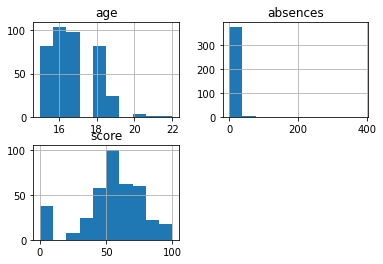

In [15]:
st.hist()

## age - возраст ученика (от 15 до 22)

<AxesSubplot:>

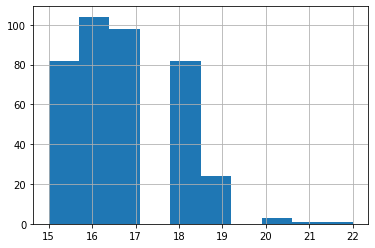

In [16]:
st.age.hist()

In [17]:
st.age.describe()

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

In [18]:
outliers(st, 'age')

"Границы выбросов 'age': [13.0; 21.0]"

Посмотрим на выбросы

In [19]:
st.query('age>21')

,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,kindergarten,higher,internet,romantic,fam_rel,freetime,go_out,health,absences,score
247,GP,M,22,U,GT3,T,3.0,1.0,services,services,other,mother,1.0,1.0,3.0,no,no,no,no,no,no,yes,yes,5.0,4.0,5.0,1.0,16.0,40.0


По формуле получается всего 1 выброс, но по факту есть единичные значения с 20 до 22 лет. Посмотрим на них

In [20]:
st.query('age>19')

,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,kindergarten,higher,internet,romantic,fam_rel,freetime,go_out,health,absences,score
247,GP,M,22,U,GT3,T,3.0,1.0,services,services,other,mother,1.0,1.0,3.0,no,no,no,no,no,no,yes,yes,5.0,4.0,5.0,1.0,16.0,40.0
306,GP,M,20,U,GT3,A,3.0,2.0,services,other,course,other,1.0,1.0,0.0,no,no,no,yes,yes,yes,no,no,5.0,5.0,3.0,5.0,0.0,90.0
376,MS,F,20,NaN,GT3,T,4.0,2.0,health,other,course,NaN,2.0,3.0,2.0,no,yes,yes,no,no,yes,yes,yes,5.0,4.0,3.0,3.0,4.0,75.0
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0


Данных о студентах старше 19 мало, похоже на частные случаи. Уберем их.

<AxesSubplot:>

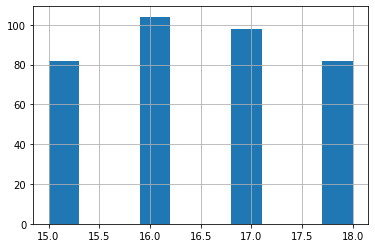

In [21]:
st = st.query('age<19')
st.age.hist()

## absences — количество пропущенных занятий

<AxesSubplot:>

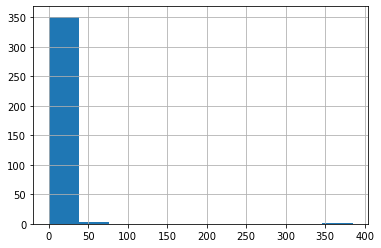

In [22]:
st.absences.hist()

In [23]:
st.absences.describe()

count    355.000000
mean       6.526761
std       21.582616
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

Посмотрим выбросы

In [24]:
outliers(st, 'absences')

"Границы выбросов 'absences': [-12.0; 20.0]"

In [25]:
st.query('absences>20')

,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,kindergarten,higher,internet,romantic,fam_rel,freetime,go_out,health,absences,score
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,no,NaN,no,yes,no,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,home,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,yes,yes,no,4.0,NaN,3.0,5.0,54.0,55.0
103,GP,F,15,U,GT3,T,3.0,2.0,services,other,home,mother,2.0,2.0,0.0,yes,yes,yes,no,yes,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0
183,GP,F,17,U,LE3,NaN,3.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,no,yes,no,yes,yes,yes,yes,yes,5.0,3.0,3.0,1.0,56.0,40.0
198,GP,F,17,U,GT3,NaN,4.0,4.0,services,teacher,home,mother,2.0,1.0,1.0,no,yes,no,no,yes,yes,NaN,no,4.0,2.0,4.0,2.0,24.0,90.0
205,GP,F,17,U,GT3,T,3.0,4.0,at_home,services,home,mother,1.0,3.0,1.0,no,yes,yes,no,yes,yes,yes,yes,4.0,4.0,3.0,5.0,28.0,45.0
216,GP,F,17,U,GT3,T,4.0,3.0,other,NaN,reputation,mother,1.0,2.0,2.0,no,no,yes,no,yes,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,NaN,no,no,yes,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
260,GP,F,18,U,GT3,NaN,4.0,3.0,NaN,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,yes,3.0,1.0,2.0,2.0,21.0,90.0
276,GP,F,18,R,GT3,A,3.0,2.0,other,services,home,mother,2.0,2.0,0.0,no,NaN,no,no,no,no,yes,yes,NaN,1.0,1.0,5.0,75.0,45.0


Руководствуясь формулой и сдравым смыслом, мы можем убрать строку 222, т.к. 385 пропусков, никаких доп. занятий и активности 85 баллов - это очень странно. Остальные данные мы оставим, их и так мало.

In [26]:
st = st.query('absences != 385')

<AxesSubplot:>

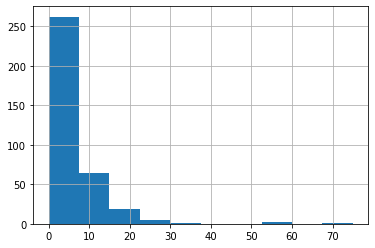

In [27]:
st.absences.hist()

## score — баллы по госэкзамену по математике

<AxesSubplot:>

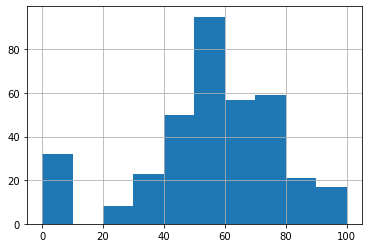

In [28]:
st.score.hist()

In [29]:
print("Количество пропусков в столбце 'score':", st.score.isnull().sum())

Количество пропусков в столбце 'score': 3


Т.к. эти значения решающие для нас, лучше просто убрать эти пропуски. Данные будут чище.

In [30]:
st = st.dropna(subset=['score'])

In [31]:
outliers(st, 'score')

"Границы выбросов 'score': [7.5; 107.5]"

По графику видно, формула выбросов в нашем случае помечает как выбросы интересующую нас группу риска, поэтому будем считать, что выбросов нет.

# Посмотрим на уникальные значения для номинативных переменных

In [32]:
get_unique(st)

{'school': 2,
 'sex': 2,
 'address': 2,
 'fam_size': 2,
 'p_status': 2,
 'm_edu': 5.0,
 'f_edu': 6.0,
 'm_job': 5,
 'f_job': 5,
 'reason': 4,
 'guardian': 3,
 'travel_time': 4.0,
 'study_time': 4.0,
 'failures': 4.0,
 'school_sup': 2,
 'fam_sup': 2,
 'paid': 2,
 'activities': 2,
 'kindergarten': 2,
 'higher': 2,
 'internet': 2,
 'romantic': 2,
 'fam_rel': 6.0,
 'freetime': 5.0,
 'go_out': 5.0,
 'health': 5.0}

## school — аббревиатура школы, в которой учится ученик

In [33]:
uniq_null(st, 'school')

['GP', 'MS']
Categories (2, object): ['GP', 'MS']
GP    325
MS     37
Name: school, dtype: int64
пропусков: 0


От школы MS представлено намного меньше учеников.

## sex — пол ученика ('F' - женский, 'M' - мужской)

In [34]:
uniq_null(st, 'sex')

['F', 'M']
Categories (2, object): ['F', 'M']
F    189
M    173
Name: sex, dtype: int64
пропусков: 0


## address — тип адреса ученика ('U' - городской, 'R' - за городом)

In [35]:
uniq_null(st, 'address')

['U', NaN, 'R']
Categories (2, object): ['U', 'R']
U    272
R     76
Name: address, dtype: int64
пропусков: 14


Также наблюдается большая разность между количеством повторяющихся значений. Присутствуют пропуски.

## fam_size — размер семьи('LE3' <= 3, 'GT3' >3)

In [36]:
uniq_null(st, 'fam_size')

[NaN, 'GT3', 'LE3']
Categories (2, object): ['GT3', 'LE3']
GT3    235
LE3    101
Name: fam_size, dtype: int64
пропусков: 26


## p_status — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

In [37]:
uniq_null(st, 'p_status')

['A', NaN, 'T']
Categories (2, object): ['A', 'T']
T    289
A     32
Name: p_status, dtype: int64
пропусков: 41


## m_edu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [38]:
uniq_null(st, 'm_edu')

[4.0, 1.0, 3.0, 2.0, NaN, 0.0]
Categories (5, float64): [4.0, 1.0, 3.0, 2.0, 0.0]
4.0    127
2.0     94
3.0     87
1.0     49
0.0      2
Name: m_edu, dtype: int64
пропусков: 3


## f_edu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [39]:
uniq_null(st, 'f_edu')

[4.0, 1.0, 2.0, 3.0, 40.0, NaN, 0.0]
Categories (6, float64): [4.0, 1.0, 2.0, 3.0, 40.0, 0.0]
2.0     99
3.0     87
4.0     86
1.0     64
0.0      2
40.0     1
Name: f_edu, dtype: int64
пропусков: 23


в описании сказано, что значение этой переменной изменяется от 0 до 4, а тут есть 1 значение 40. Наверное опечатка, заменим на 4.

In [40]:
st.query('f_edu == 40')

,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,kindergarten,higher,internet,romantic,fam_rel,freetime,go_out,health,absences,score
11,GP,F,15,U,GT3,NaN,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


In [41]:
st.at[11, 'f_edu' ] = 4
st['f_edu'].cat.remove_unused_categories(inplace=True)

проверяем

In [42]:
uniq_null(st, 'f_edu')

[4.0, 1.0, 2.0, 3.0, NaN, 0.0]
Categories (5, float64): [4.0, 1.0, 2.0, 3.0, 0.0]
2.0    99
4.0    87
3.0    87
1.0    64
0.0     2
Name: f_edu, dtype: int64
пропусков: 23


## m_job — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [43]:
uniq_null(st, 'm_job')

['at_home', 'health', 'other', 'services', 'teacher', NaN]
Categories (5, object): ['at_home', 'health', 'other', 'services', 'teacher']
other       119
services     86
teacher      54
at_home      54
health       30
Name: m_job, dtype: int64
пропусков: 19


## f_job — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [44]:
uniq_null(st, 'f_job')

['teacher', 'other', NaN, 'health', 'services', 'at_home']
Categories (5, object): ['teacher', 'other', 'health', 'services', 'at_home']
other       182
services     91
teacher      28
health       14
at_home      13
Name: f_job, dtype: int64
пропусков: 34


## reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

In [45]:
uniq_null(st, 'reason')

['course', 'other', 'home', 'reputation', NaN]
Categories (4, object): ['course', 'other', 'home', 'reputation']
course        129
reputation     94
home           93
other          30
Name: reason, dtype: int64
пропусков: 16


## guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

In [46]:
uniq_null(st, 'guardian')

['mother', 'father', 'other', NaN]
Categories (3, object): ['mother', 'father', 'other']
mother    242
father     84
other       8
Name: guardian, dtype: int64
пропусков: 28


## travel_time — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

In [47]:
uniq_null(st, 'travel_time')

[2.0, 1.0, 3.0, NaN, 4.0]
Categories (4, float64): [2.0, 1.0, 3.0, 4.0]
1.0    221
2.0     88
3.0     19
4.0      7
Name: travel_time, dtype: int64
пропусков: 27


## study_time — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

In [48]:
uniq_null(st, 'study_time')

[2.0, 3.0, 1.0, NaN, 4.0]
Categories (4, float64): [2.0, 3.0, 1.0, 4.0]
2.0    177
1.0     95
3.0     58
4.0     26
Name: study_time, dtype: int64
пропусков: 6


##  failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

In [49]:
uniq_null(st, 'failures')

[0.0, 3.0, NaN, 2.0, 1.0]
Categories (4, float64): [0.0, 3.0, 2.0, 1.0]
0.0    283
1.0     37
3.0     11
2.0     11
Name: failures, dtype: int64
пропусков: 20


##  school_sup — дополнительная образовательная поддержка (yes или no)

In [50]:
uniq_null(st, 'school_sup')

['yes', 'no', NaN]
Categories (2, object): ['yes', 'no']
no     308
yes     47
Name: school_sup, dtype: int64
пропусков: 7


## fam_sup — семейная образовательная поддержка (yes или no)

In [51]:
uniq_null(st, 'fam_sup')

['no', 'yes', NaN]
Categories (2, object): ['no', 'yes']
yes    205
no     122
Name: fam_sup, dtype: int64
пропусков: 35


## paid — дополнительные платные занятия по математике (yes или no)

In [52]:
uniq_null(st, 'paid')

['no', NaN, 'yes']
Categories (2, object): ['no', 'yes']
no     179
yes    146
Name: paid, dtype: int64
пропусков: 37


## activities — дополнительные внеучебные занятия (yes или no)

In [53]:
uniq_null(st, 'activities')

['no', 'yes', NaN]
Categories (2, object): ['no', 'yes']
yes    182
no     166
Name: activities, dtype: int64
пропусков: 14


 ## kindergarten — посещал детский сад (yes или no)

In [54]:
uniq_null(st, 'kindergarten')

['yes', 'no', NaN]
Categories (2, object): ['yes', 'no']
yes    282
no      68
Name: kindergarten, dtype: int64
пропусков: 12


## higher — хочет получить высшее образование (yes или no)

In [55]:
uniq_null(st, 'higher')

['yes', NaN, 'no']
Categories (2, object): ['yes', 'no']
yes    328
no      15
Name: higher, dtype: int64
пропусков: 19


## internet — наличие интернета дома (yes или no)

In [56]:
uniq_null(st, 'internet')

[NaN, 'yes', 'no']
Categories (2, object): ['yes', 'no']
yes    284
no      47
Name: internet, dtype: int64
пропусков: 31


## romantic — в романтических отношениях (yes или no)

In [57]:
uniq_null(st, 'romantic')

['no', NaN, 'yes']
Categories (2, object): ['no', 'yes']
no     221
yes    111
Name: romantic, dtype: int64
пропусков: 30


## fam_rel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

In [58]:
uniq_null(st, 'fam_rel')

[4.0, 5.0, 3.0, NaN, -1.0, 2.0, 1.0]
Categories (6, float64): [4.0, 5.0, 3.0, -1.0, 2.0, 1.0]
4.0     165
5.0      90
3.0      58
2.0      15
1.0       7
-1.0      1
Name: fam_rel, dtype: int64
пропусков: 26


Так же подозрительное отрицательное значение. Заменим.

In [59]:
st.query('fam_rel == -1')

,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,kindergarten,higher,internet,romantic,fam_rel,freetime,go_out,health,absences,score
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0


In [60]:
st.at[25, 'fam_rel' ] = 1
st['fam_rel'].cat.remove_unused_categories(inplace=True)

In [61]:
uniq_null(st, 'fam_rel')

[4.0, 5.0, 3.0, NaN, 1.0, 2.0]
Categories (5, float64): [4.0, 5.0, 3.0, 1.0, 2.0]
4.0    165
5.0     90
3.0     58
2.0     15
1.0      8
Name: fam_rel, dtype: int64
пропусков: 26


## freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

In [62]:
uniq_null(st, 'freetime')

[3.0, 2.0, 4.0, 1.0, 5.0, NaN]
Categories (5, float64): [3.0, 2.0, 4.0, 1.0, 5.0]
3.0    145
4.0    102
2.0     59
5.0     32
1.0     17
Name: freetime, dtype: int64
пропусков: 7


## go_out — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

In [63]:
uniq_null(st, 'go_out')

[4.0, 3.0, 2.0, 1.0, 5.0, NaN]
Categories (5, float64): [4.0, 3.0, 2.0, 1.0, 5.0]
3.0    118
2.0     94
4.0     73
5.0     50
1.0     20
Name: go_out, dtype: int64
пропусков: 7


## health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

In [64]:
uniq_null(st, 'health')

[3.0, 5.0, 1.0, 2.0, 4.0, NaN]
Categories (5, float64): [3.0, 5.0, 1.0, 2.0, 4.0]
5.0    129
3.0     77
4.0     58
1.0     44
2.0     40
Name: health, dtype: int64
пропусков: 14


# Корреляционный анализ количественных переменных

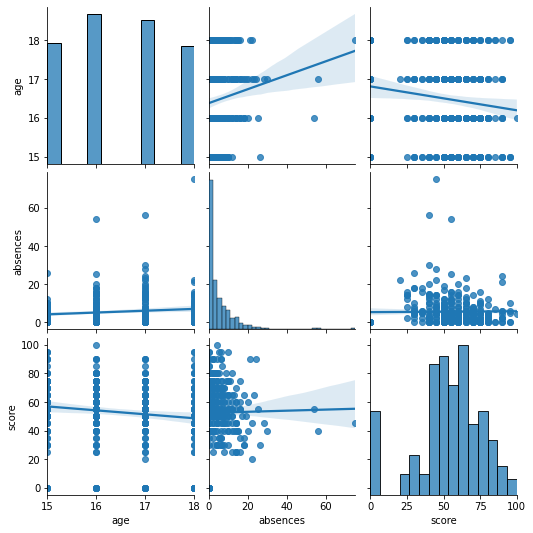

In [65]:
sns.pairplot(st[['age', 'absences', 'score']], kind = 'reg')

In [66]:
st.corr()

,age,absences,score
age,1.000000,0.131231,-0.130529
absences,0.131231,1.000000,0.013353
score,-0.130529,0.013353,1.000000


Более коррелирующими значениями оказались переменные absences и age.

Между age и score наблюдается отрицательная корреляция.

# Выбросы

Во многих столбцах присутствуют пропуски. От некоторых мы уже избавились, либо заполнили. Остальные будем заменять значением моды.

In [67]:
cat_cols = st.select_dtypes(include='category').columns.values  # список столбцов
for col in cat_cols:
    nan_count = st[col].isnull().sum()
    
    if nan_count > 0:               
        top = st[col].describe()['top']     # Получаем моду (топовое значение для col)
        st[col] = st[col].fillna(top)   # Заполняем NaN этим значением 
        print(f"найдено и заменено  {nan_count} пропущенных значения (NaN) для '{col}'")

найдено и заменено  14 пропущенных значения (NaN) для 'address'
найдено и заменено  26 пропущенных значения (NaN) для 'fam_size'
найдено и заменено  41 пропущенных значения (NaN) для 'p_status'
найдено и заменено  3 пропущенных значения (NaN) для 'm_edu'
найдено и заменено  23 пропущенных значения (NaN) для 'f_edu'
найдено и заменено  19 пропущенных значения (NaN) для 'm_job'
найдено и заменено  34 пропущенных значения (NaN) для 'f_job'
найдено и заменено  16 пропущенных значения (NaN) для 'reason'
найдено и заменено  28 пропущенных значения (NaN) для 'guardian'
найдено и заменено  27 пропущенных значения (NaN) для 'travel_time'
найдено и заменено  6 пропущенных значения (NaN) для 'study_time'
найдено и заменено  20 пропущенных значения (NaN) для 'failures'
найдено и заменено  7 пропущенных значения (NaN) для 'school_sup'
найдено и заменено  35 пропущенных значения (NaN) для 'fam_sup'
найдено и заменено  37 пропущенных значения (NaN) для 'paid'
найдено и заменено  14 пропущенных значен

# Анализ категориальных переменных

Посмотрим на изменение баллов в зависимости от разных значений.

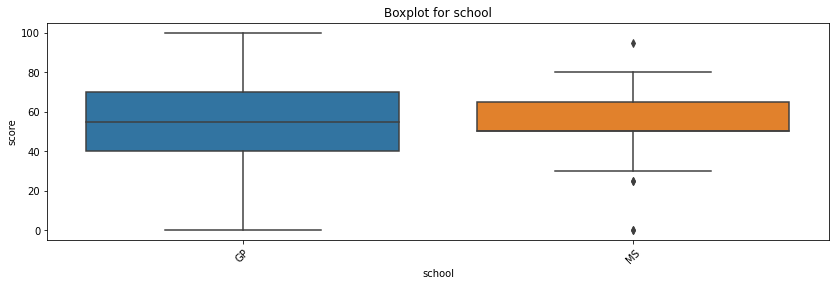

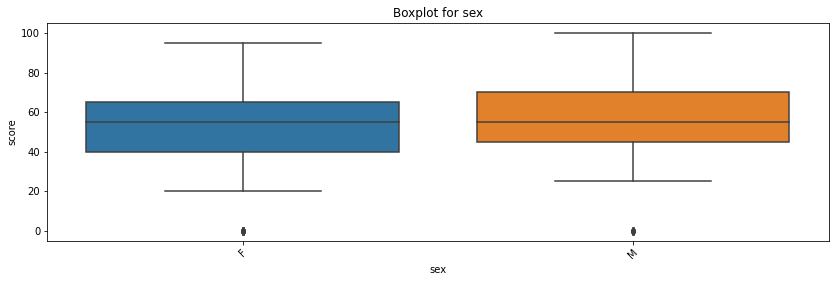

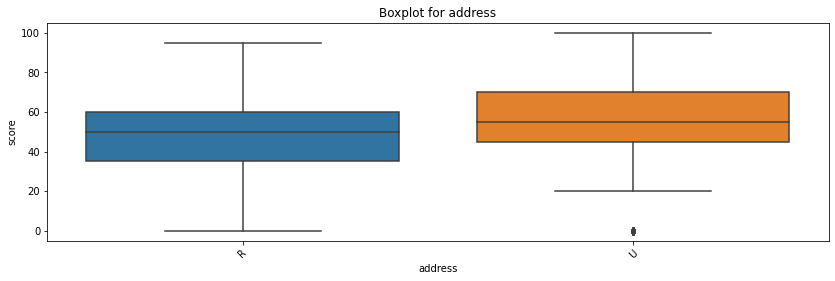

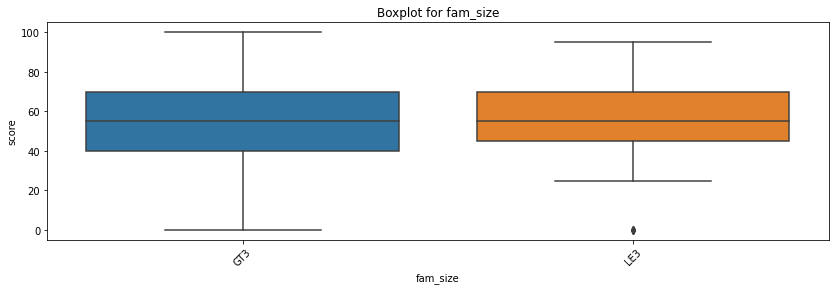

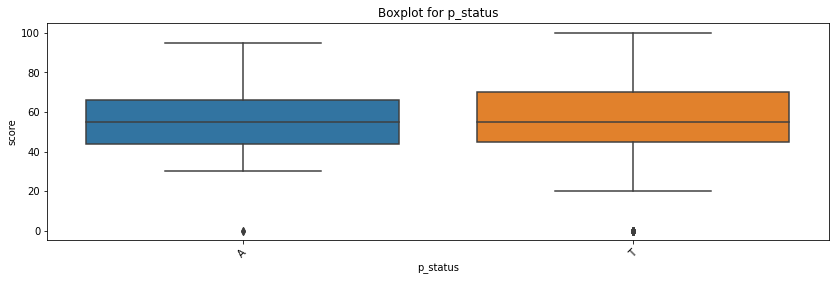

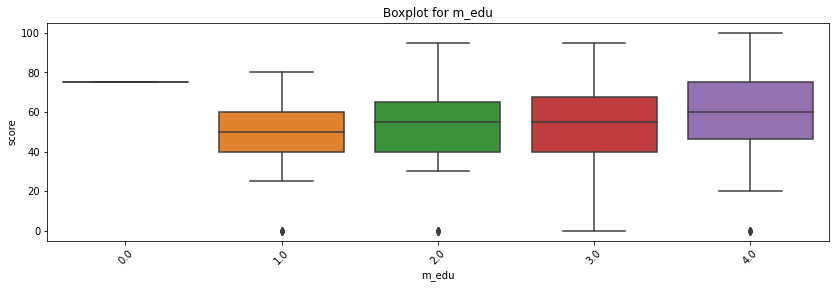

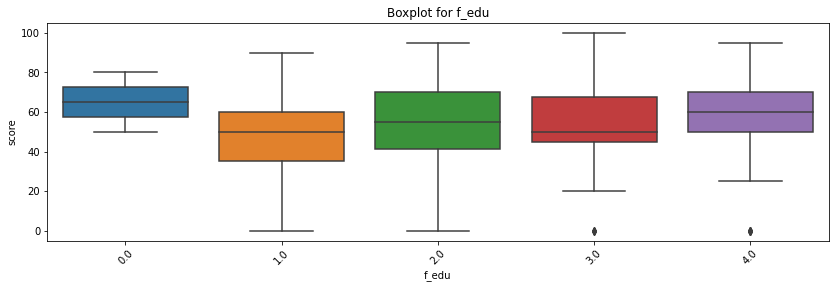

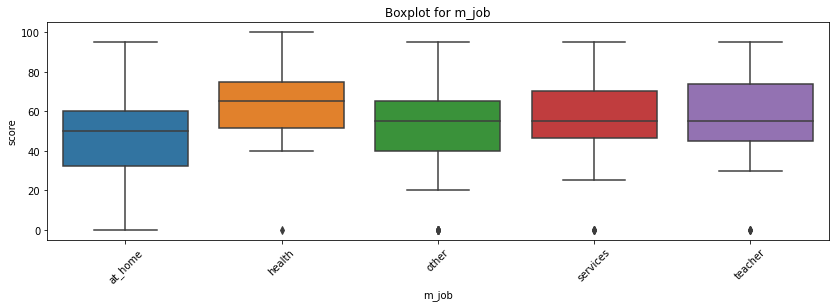

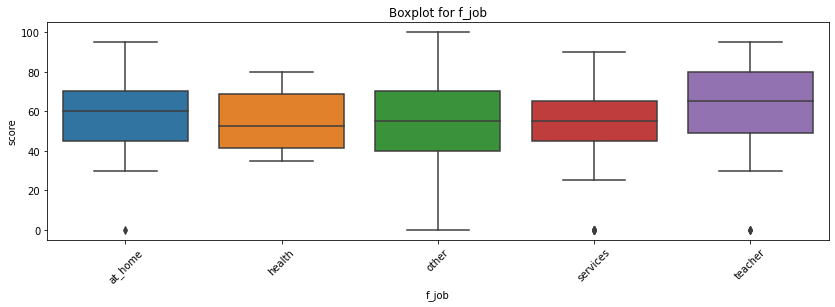

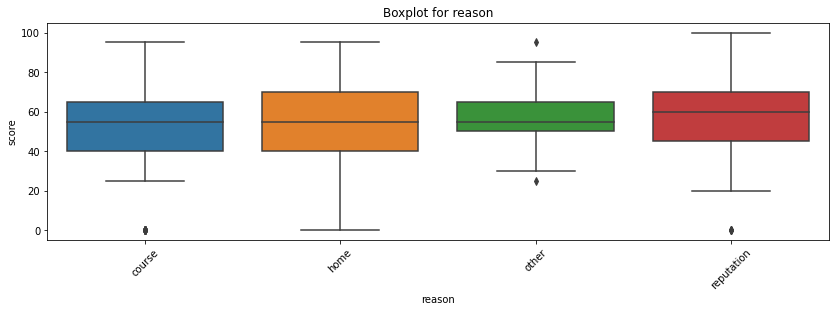

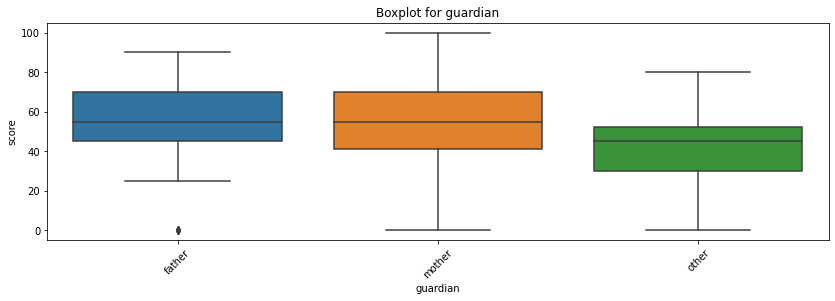

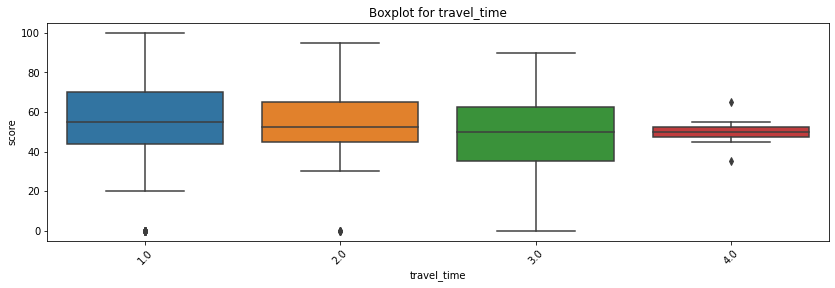

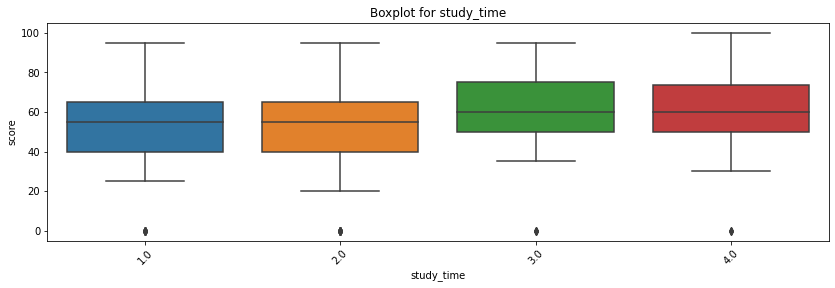

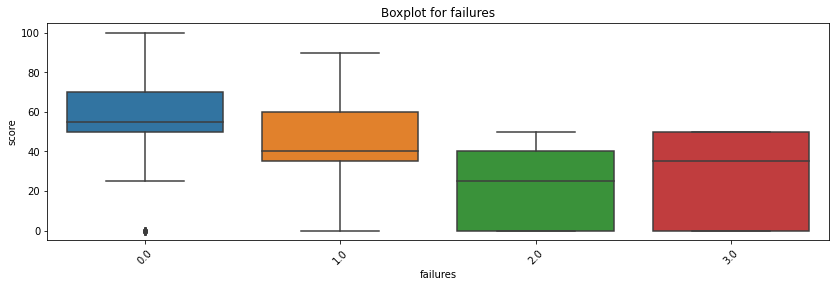

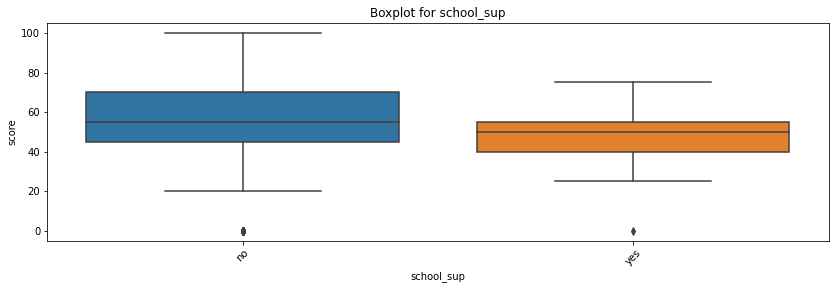

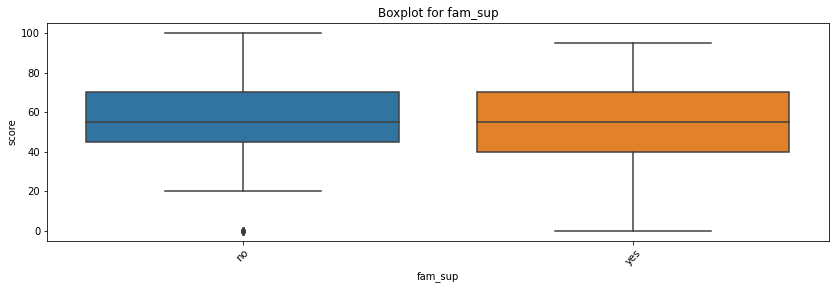

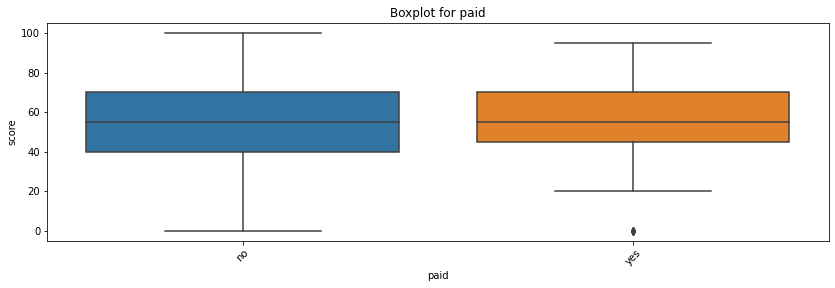

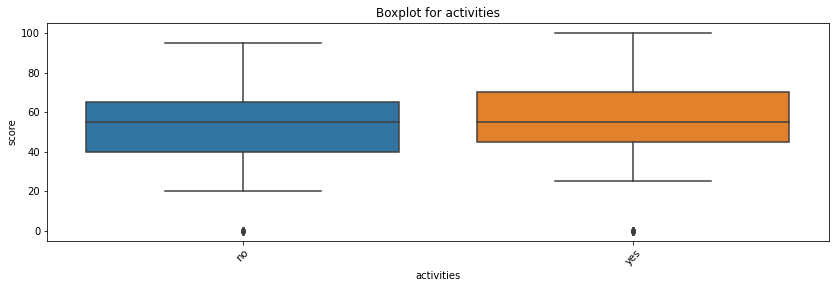

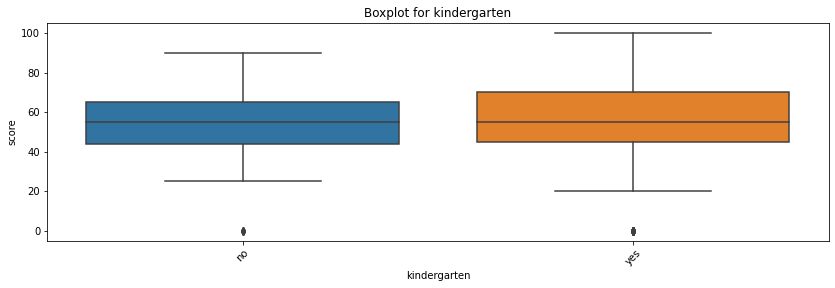

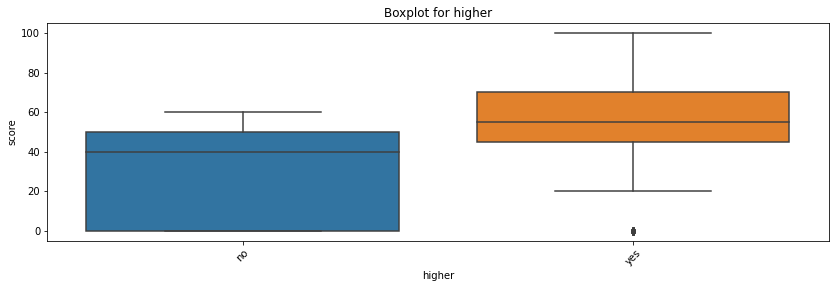

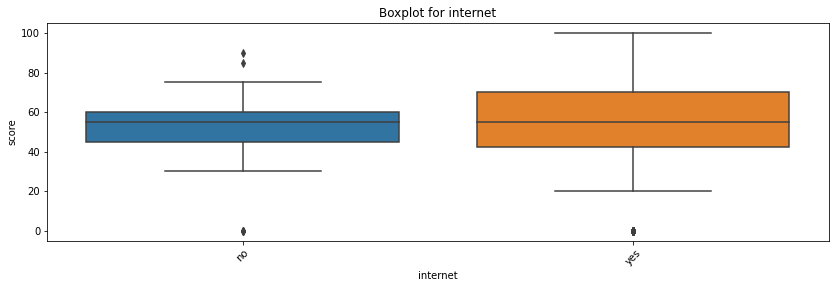

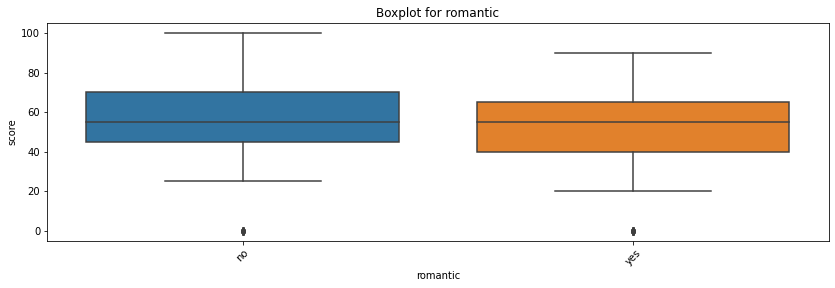

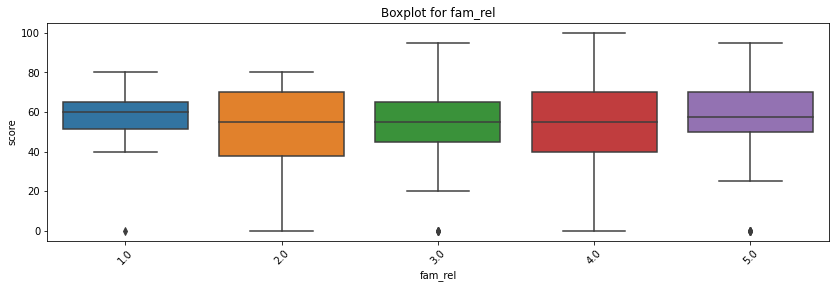

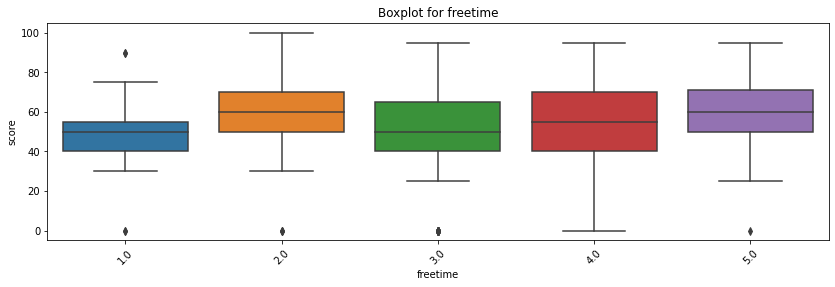

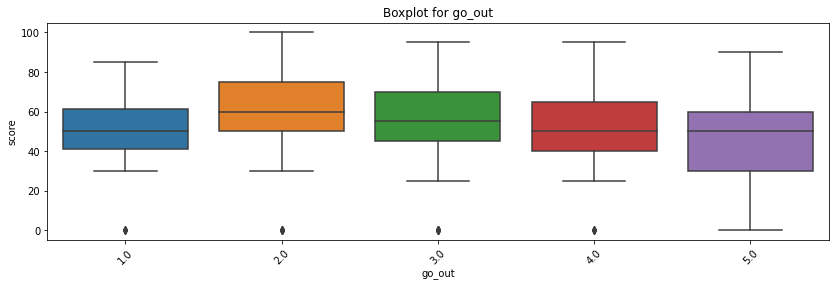

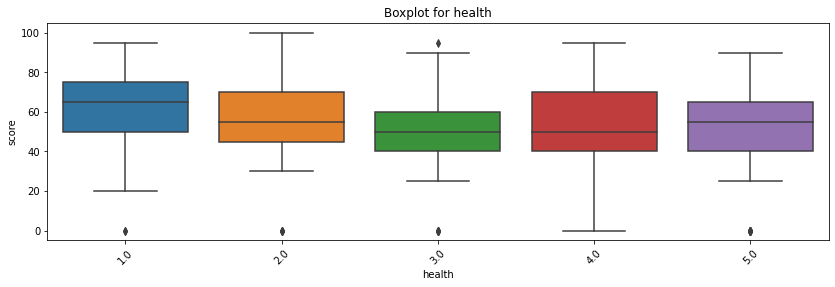

In [68]:
for column in st:
    if column in ['age','absences','score']:
        continue
    else:
        boxplot(column)

## Проведем тест Стьюдента на всех категориальных или порядковых признаках

In [69]:
for col in st.select_dtypes(include='category').columns:
    student_test(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки m_edu
Найдены статистически значимые различия для колонки m_job
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки school_sup
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки go_out


In [70]:
st_for_model = st.loc[:, [
    'sex', 'address', 'm_edu', 'm_job', 'failures', 'school_sup', 'higher', 'romantic', 'go_out', 'age', 'absences'
]]
st_for_model.head()

,sex,address,m_edu,m_job,failures,school_sup,higher,romantic,go_out,age,absences
0,F,U,4.0,at_home,0.0,yes,yes,no,4.0,18,6.0
1,F,U,1.0,at_home,0.0,no,yes,no,3.0,17,4.0
2,F,U,1.0,at_home,3.0,yes,yes,no,2.0,15,10.0
3,F,U,4.0,health,0.0,no,yes,yes,2.0,15,2.0
4,F,U,3.0,other,0.0,no,yes,no,2.0,16,4.0


# Выводы

в результате EDA для анализа влияниz условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике,
были получены следующие выводы:

Данные достаточно полные, в среднем 5-10% пустых значений на признак.

Было удалено 5 выбросов в столбце age и 1 - в столбце absences.

Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это sex, address, m_edu, m_job, failures, school_sup, higher, romantic, go_out, age, absences.